In [31]:
import yfinance as yahooFinance

# in order to specify start date and
# end date we need datetime package
import datetime

# startDate , as per our convenience we can modify
startDate = datetime.datetime(2019, 5, 31)

# endDate , as per our convenience we can modify
endDate = datetime.datetime(2021, 1, 30)
meta = yahooFinance.Ticker("META")

# pass the parameters as the taken dates for start and end
df = meta.history(start=startDate, end=endDate)
df['Date'] = df.index


In [54]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2019-05-31 00:00:00-04:00,180.279999,180.539993,177.160004,177.470001,15226500,0.0,0.0,2019-05-31 00:00:00-04:00
2019-06-03 00:00:00-04:00,175.000000,175.050003,161.009995,164.149994,56059600,0.0,0.0,2019-06-03 00:00:00-04:00
2019-06-04 00:00:00-04:00,163.710007,168.279999,160.839996,167.500000,46044300,0.0,0.0,2019-06-04 00:00:00-04:00
2019-06-05 00:00:00-04:00,167.479996,168.720001,164.630005,168.169998,19758300,0.0,0.0,2019-06-05 00:00:00-04:00
2019-06-06 00:00:00-04:00,168.300003,169.699997,167.229996,168.330002,12446400,0.0,0.0,2019-06-06 00:00:00-04:00


In [1]:
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
exp = TimeSeriesExperiment()
exp.setup(data=df, fh=12, session_id=42, fig_kwargs = {"template": "simple_white","hoverinfo":"none"})

top4 = exp.compare_models(n_select = 4)

ModuleNotFoundError: No module named 'pycaret'

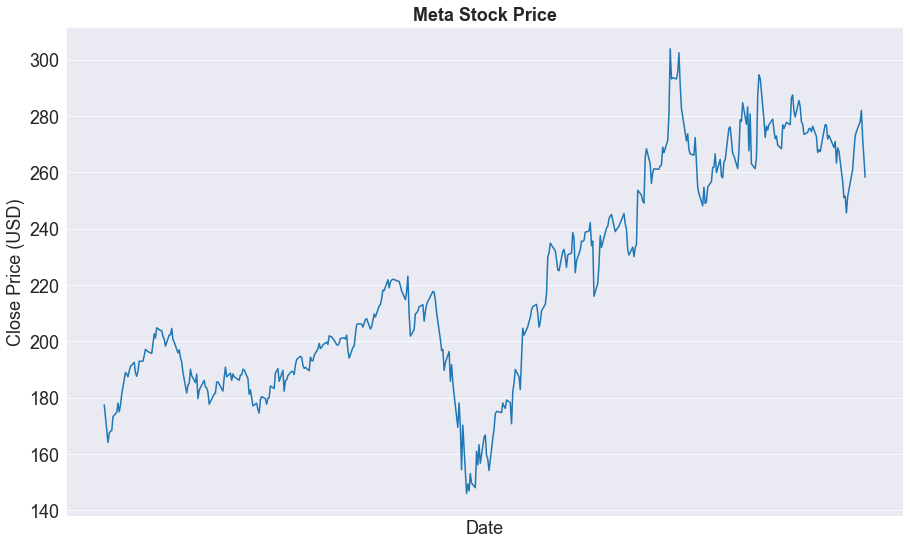

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(df[['Close']])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title("Meta Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

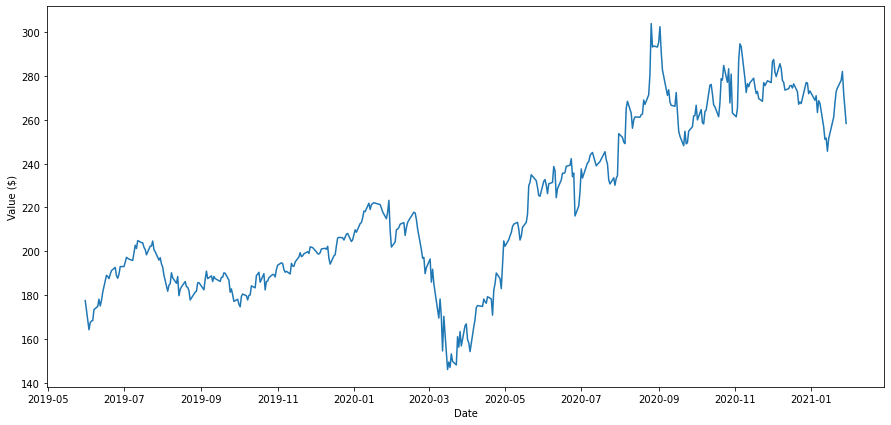

In [33]:
plt.figure(figsize=(15,7))
plt.plot(df.Close)
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.rcParams.update({'font.size': 18})

In [81]:
price = df[['Close']]
price.describe()

,Close
count,421.000000
mean,220.268052
std,38.162062
min,146.009995
25%,188.889999
50%,210.100006
75%,258.660004
max,303.910004


In [82]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/jb/bxbmc2q970l2l1j4xlhcq9980000gn/T/ipykernel_61943/68737012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [83]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


In [84]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (321, 19, 1)
y_train.shape =  (321, 1)
x_test.shape =  (80, 19, 1)
y_test.shape =  (80, 1)


In [85]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [86]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [87]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out



In [88]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [89]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.18457446992397308
Epoch  1 MSE:  0.14490176737308502
Epoch  2 MSE:  0.14222437143325806
Epoch  3 MSE:  0.12037329375743866
Epoch  4 MSE:  0.09658481180667877
Epoch  5 MSE:  0.07092952728271484
Epoch  6 MSE:  0.03597702831029892
Epoch  7 MSE:  0.07972366362810135
Epoch  8 MSE:  0.04820455610752106
Epoch  9 MSE:  0.05584840849041939
Epoch  10 MSE:  0.034765440970659256
Epoch  11 MSE:  0.021273132413625717
Epoch  12 MSE:  0.020922640338540077
Epoch  13 MSE:  0.02636060118675232
Epoch  14 MSE:  0.02956203557550907
Epoch  15 MSE:  0.027597635984420776
Epoch  16 MSE:  0.02277613803744316
Epoch  17 MSE:  0.018881717696785927
Epoch  18 MSE:  0.01856212317943573
Epoch  19 MSE:  0.021321842446923256
Epoch  20 MSE:  0.02305660955607891
Epoch  21 MSE:  0.021357061341404915
Epoch  22 MSE:  0.017864951863884926
Epoch  23 MSE:  0.014945208095014095
Epoch  24 MSE:  0.013599498197436333
Epoch  25 MSE:  0.013652727007865906
Epoch  26 MSE:  0.014205261133611202
Epoch  27 MSE:  0.01417520

In [90]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

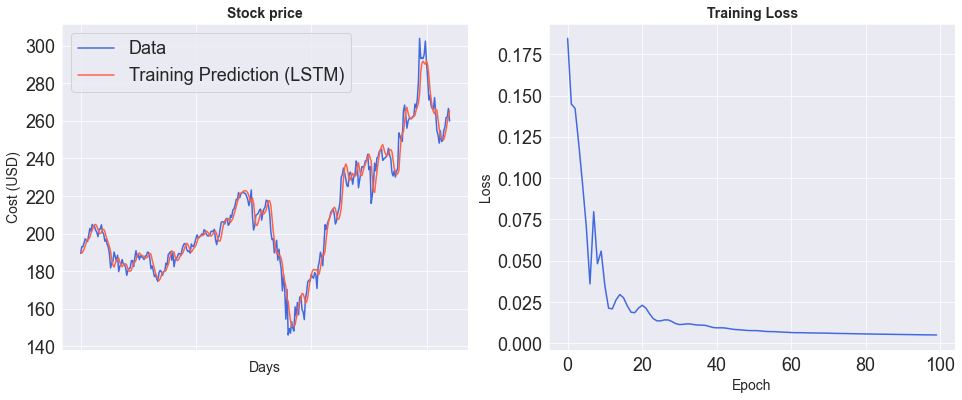

In [91]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [92]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 5.63 RMSE
Test Score: 7.63 RMSE


In [93]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [94]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

# GRU

In [95]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [97]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [98]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.15949758887290955
Epoch  1 MSE:  0.13998040556907654
Epoch  2 MSE:  0.09043142199516296
Epoch  3 MSE:  0.05877438932657242
Epoch  4 MSE:  0.029427338391542435
Epoch  5 MSE:  0.012777759693562984
Epoch  6 MSE:  0.04253051429986954
Epoch  7 MSE:  0.024475036188960075
Epoch  8 MSE:  0.017030877992510796
Epoch  9 MSE:  0.00984666496515274
Epoch  10 MSE:  0.012357782572507858
Epoch  11 MSE:  0.01874905824661255
Epoch  12 MSE:  0.02025092951953411
Epoch  13 MSE:  0.016630997881293297
Epoch  14 MSE:  0.012254786677658558
Epoch  15 MSE:  0.009486500173807144
Epoch  16 MSE:  0.007729720324277878
Epoch  17 MSE:  0.006593257654458284
Epoch  18 MSE:  0.007721227128058672
Epoch  19 MSE:  0.010611972771584988
Epoch  20 MSE:  0.01071803830564022
Epoch  21 MSE:  0.007883026264607906
Epoch  22 MSE:  0.0059777493588626385
Epoch  23 MSE:  0.005732533521950245
Epoch  24 MSE:  0.005829247646033764
Epoch  25 MSE:  0.005960207432508469
Epoch  26 MSE:  0.0064703319221735
Epoch  27 MSE:  0.007

In [99]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

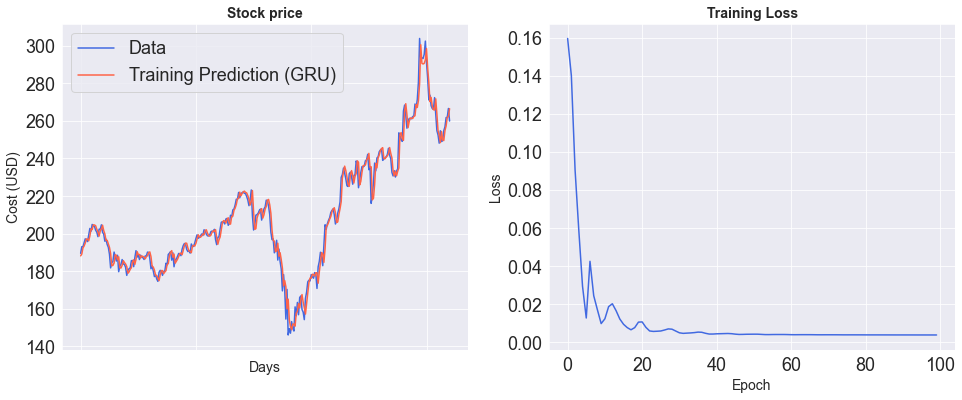

In [100]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


In [101]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 4.91 RMSE
Test Score: 6.26 RMSE


In [102]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)


In [103]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [104]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,5.627468,4.909559
Test RMSE,7.632167,6.256837
Train Time,6.331581,15.352005
